         signalname      rbar       vol     tstat samptype
0                AM  0.488124  4.150635  3.420589      nan
1               AOP  0.166776  2.621598  1.486498  in-samp
2  AbnormalAccruals  0.183183  2.160653  2.066303  in-samp
3          Accruals  0.416461  1.850835  6.498143      nan
4        AccrualsBM  1.296512  5.175324  6.575799      nan
         signalname      rbar       vol  tstat samptype
0                AM  0.488124  4.150635    NaN      nan
1               AOP  0.166776  2.621598    NaN  in-samp
2  AbnormalAccruals  0.183183  2.160653    NaN  in-samp
3          Accruals  0.416461  1.850835    NaN      nan
4        AccrualsBM  1.296512  5.175324    NaN      nan


C:\Users\rra3\AppData\Local\Temp\ipykernel_24220\1561337802.py:105: RuntimeWarning: divide by zero encountered in divide
  F_emp = np.cumsum(np.histogram(czsum_filtered, bins=50)[0] / len(czsum_filtered))
C:\Users\rra3\AppData\Local\Temp\ipykernel_24220\1561337802.py:105: RuntimeWarning: invalid value encountered in divide
  F_emp = np.cumsum(np.histogram(czsum_filtered, bins=50)[0] / len(czsum_filtered))



      
# Create subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))

# Plot 1
ax1.bar(dat_all.loc[dat_all['group'] == 'emp', 't_mid'], dat_all.loc[dat_all['group'] == 'emp', 'prob'], color='gray', alpha=0.6)
ax1.plot(dat_all.loc[dat_all['group'] == 'null', 't_mid'], dat_all.loc[dat_all['group'] == 'null', 'prob'], label=groupdat.loc[groupdat['group'] == 'null', 'labels'].iloc[0], linestyle=groupdat.loc[groupdat['group'] == 'null', 'linetype'].iloc[0], color='red', linewidth=2)
ax1.set_xlim(0, 15)
ax1.set_ylim(0, 0.2)
ax1.set_xlabel(r'Published t-statistic $t_i$')
ax1.set_ylabel('Frequency')
ax1.legend(loc='upper right')

# Plot 2
ax2.bar(dat_all.loc[dat_all['group'] == 'emp', 't_mid'], dat_all.loc[dat_all['group'] == 'emp', 'prob'], color='gray', alpha=0.6)
ax2.plot(dat_all.loc[dat_all['group'] == 'miss', 't_mid'], dat_all.loc[dat_all['group'] == 'miss', 'prob'], label=groupdat.loc[groupdat['group'] == 'miss', 'labels'].iloc[0], linestyle=groupdat.loc[groupdat

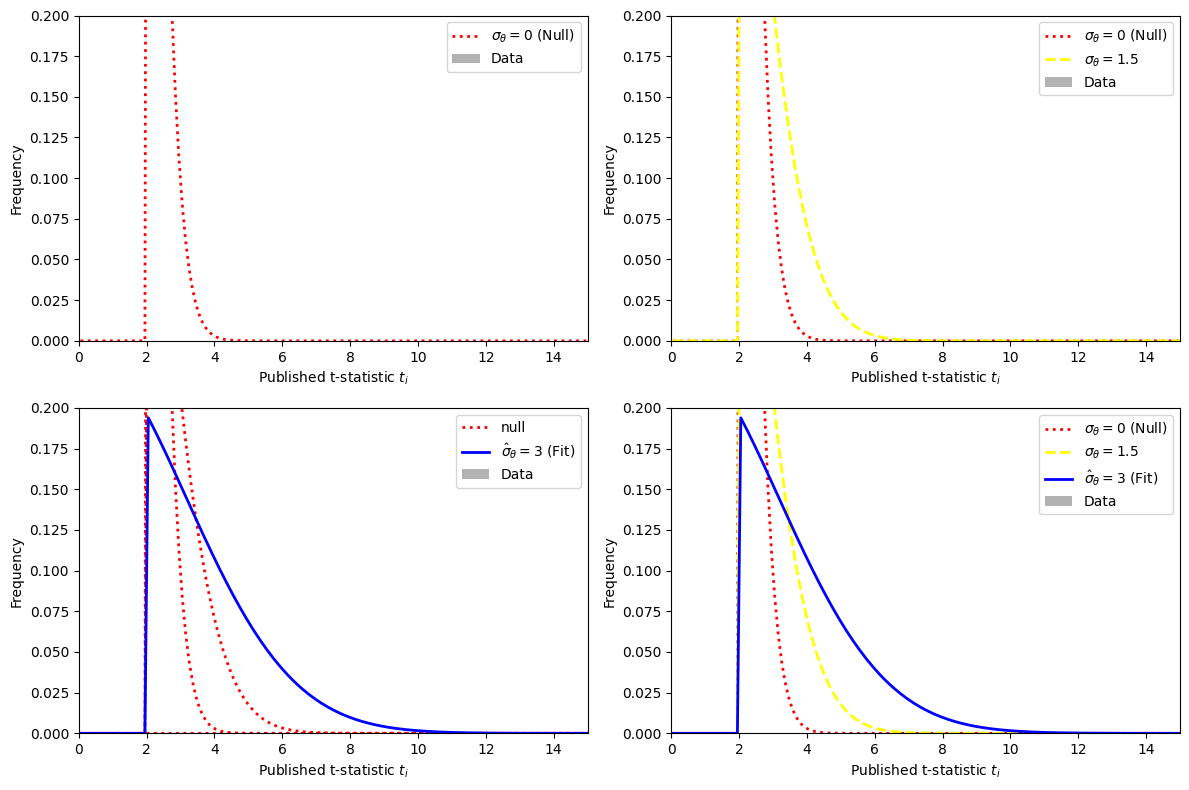

In [9]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from matplotlib import rc

# Load data
cz_all = pd.read_csv(r"C:\Users\rra3\Desktop\spring_24\assetpricereps\asset-pricing-replications\data\PredictorPortsFull.csv")
signaldoc = pd.read_csv(r'C:\Users\rra3\Desktop\spring_24\assetpricereps\asset-pricing-replications\data\SignalDoc.csv')
signaldoc = signaldoc.rename(columns={'Acronym': 'signalname'})
signaldoc['pubdate'] = pd.to_datetime(signaldoc['Year'].astype(str) + '-12-31')
signaldoc['sampend'] = pd.to_datetime(signaldoc['SampleEndYear'].astype(str) + '-12-31')
signaldoc['sampstart'] = pd.to_datetime(signaldoc['SampleStartYear'].astype(str) + '-01-01')
signaldoc = signaldoc.drop(columns=['Notes', 'Detailed Definition'])

# Monthly returns (czret)
czret = cz_all.loc[~cz_all['ret'].isna() & (cz_all['port'] == 'LS'), :]
czret = czret.merge(signaldoc, on='signalname', how='left')
czret['samptype'] = np.select(
    [
        (czret['date'] >= czret['sampstart']) & (czret['date'] <= czret['sampend']),
        (czret['date'] > czret['sampend']) & (czret['date'] <= czret['sampend'] + pd.DateOffset(months=36)),
        (czret['date'] > czret['pubdate'])
    ],
    ['in-samp', 'out-of-samp', 'post-pub'],
    default=np.nan
)
czret = czret[['signalname', 'date', 'ret', 'samptype', 'sampstart', 'sampend']]

# Reset index for czret
czret.reset_index(drop=True, inplace=True)

# Summary statistics by signalname and sampletype (czsum)
czsum = czret.groupby(['signalname']).apply(lambda x: pd.Series({
    'rbar': x['ret'].mean(),
    'vol': x['ret'].std(),
    'tstat': (x['ret'].mean() / x['ret'].std()) * np.sqrt(len(x)),
    'samptype': x['samptype'].iloc[0]  # Take the first samptype
})).reset_index()

print(czsum.head())
czsum['tstat'] = czsum['rbar'] / czsum['vol'] * np.sqrt(czret.groupby('signalname').size())
print(czsum.head())
# Set up
edge = np.arange(0, 20.1, 0.5)
t_left = edge[:-1]
t_right = edge[1:]
mid = t_left + np.diff(edge) / 2

edge2 = np.arange(0, 20.1, 0.1)
t_left2 = edge2[:-1]
t_right2 = edge2[1:]
mid2 = t_left2 + np.diff(edge2) / 2

# Empirical
F_emp = lambda x: np.searchsorted(np.sort(czsum.loc[czsum['samptype'] == 'in-samp', 'tstat']), x, side='right') / len(czsum.loc[czsum['samptype'] == 'in-samp', 'tstat'])
dat_emp = pd.DataFrame({
    't_mid': mid,
    'prob': F_emp(t_right) - F_emp(t_left),
    'group': 'emp'
})

# Null
rescalefac = np.mean(np.diff(edge)) / np.mean(np.diff(edge2))
pnorm_diff = (norm.cdf(t_right2) - norm.cdf(t_left2)) / (1 - norm.cdf(2)) * rescalefac * (1 - F_emp(2))
dat_null = pd.DataFrame({
    't_mid': mid2,
    'prob': np.where(mid2 > 2, pnorm_diff, 0),
    'group': 'null'
})

# Miss
sigfit = np.sqrt(1 + 1.5**2)
pnorm_diff_miss = (norm.cdf(t_right2, scale=sigfit) - norm.cdf(t_left2, scale=sigfit)) / (1 - norm.cdf(2, scale=sigfit)) * rescalefac * (1 - F_emp(2))
dat_miss = pd.DataFrame({
    't_mid': mid2,
    'prob': np.where(mid2 > 2, pnorm_diff_miss, 0),
    'group': 'miss'
})

# Fit
sigfit = np.sqrt(1 + 3**2)
pnorm_diff_fit = (norm.cdf(t_right2, scale=sigfit) - norm.cdf(t_left2, scale=sigfit)) / (1 - norm.cdf(2, scale=sigfit)) * rescalefac * (1 - F_emp(2))
dat_fit = pd.DataFrame({
    't_mid': mid2,
    'prob': np.where(mid2 > 2, pnorm_diff_fit, 0),
    'group': 'fit'
})

# Merge and factor group
dat_all = pd.concat([dat_emp, dat_null, dat_miss, dat_fit])
dat_all['group'] = pd.Categorical(dat_all['group'], categories=['emp', 'null', 'miss', 'fit'])

# Plotting


groupdat = pd.DataFrame({
    'group': ['null', 'miss', 'fit'],
    'labels': [r'$\sigma_{\theta} = 0$ (Null)', r'$\sigma_{\theta} = 1.5$', r'$\hat{\sigma}_{\theta} = 3$ (Fit)'],
    'linetype': ['dotted', 'dashed', 'solid']
})
# Empirical stats
czsum_filtered = czsum.loc[czsum['samptype'] == 'in-samp', 'tstat']  # Filtered DataFrame without NaN values
czsum_filtered = czsum_filtered.dropna()  # Drop NaN values
F_emp = np.cumsum(np.histogram(czsum_filtered, bins=50)[0] / len(czsum_filtered))
t_mid = np.histogram(czsum_filtered, bins=50)[1][:-1] + np.diff(np.histogram(czsum_filtered, bins=50)[1]) / 2
dat_emp = pd.DataFrame({
    't_mid': t_mid,
    'prob': F_emp,
    'group': 'emp'
})

# Create subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))

# Plot 1
ax1.bar(dat_emp['t_mid'], dat_emp['prob'], color='gray', alpha=0.6, label='Data')
ax1.plot(dat_all.loc[dat_all['group'] == 'null', 't_mid'], dat_all.loc[dat_all['group'] == 'null', 'prob'], label=groupdat.loc[groupdat['group'] == 'null', 'labels'].iloc[0], linestyle=groupdat.loc[groupdat['group'] == 'null', 'linetype'].iloc[0], color='red', linewidth=2)
ax1.set_xlim(0, 15)
ax1.set_ylim(0, 0.2)
ax1.set_xlabel(r'Published t-statistic $t_i$')
ax1.set_ylabel('Frequency')
ax1.legend(loc='upper right')

# Plot 2
ax2.bar(dat_emp['t_mid'], dat_emp['prob'], color='gray', alpha=0.6, label='Data')
ax2.plot(dat_all.loc[dat_all['group'] == 'null', 't_mid'], dat_all.loc[dat_all['group'] == 'null', 'prob'], label=groupdat.loc[groupdat['group'] == 'null', 'labels'].iloc[0], linestyle=groupdat.loc[groupdat['group'] == 'null', 'linetype'].iloc[0], color='red', linewidth=2)
ax2.plot(dat_all.loc[dat_all['group'] == 'miss', 't_mid'], dat_all.loc[dat_all['group'] == 'miss', 'prob'], label=groupdat.loc[groupdat['group'] == 'miss', 'labels'].iloc[0], linestyle=groupdat.loc[groupdat['group'] == 'miss', 'linetype'].iloc[0], color='yellow', linewidth=2)
ax2.set_xlim(0, 15)
ax2.set_ylim(0, 0.2)
ax2.set_xlabel(r'Published t-statistic $t_i$')
ax2.set_ylabel('Frequency')
ax2.legend(loc='upper right')

# Plot 3
ax3.bar(dat_emp['t_mid'], dat_emp['prob'], color='gray', alpha=0.6, label='Data')
ax3.plot(dat_all.loc[dat_all['group'].isin(['null', 'miss']), 't_mid'], dat_all.loc[dat_all['group'].isin(['null', 'miss']), 'prob'], label='null', linestyle='dotted', color='red', linewidth=2)
ax3.plot(dat_all.loc[dat_all['group'] == 'fit', 't_mid'], dat_all.loc[dat_all['group'] == 'fit', 'prob'], label=groupdat.loc[groupdat['group'] == 'fit', 'labels'].iloc[0], linestyle=groupdat.loc[groupdat['group'] == 'fit', 'linetype'].iloc[0], color='blue', linewidth=2)
ax3.set_xlim(0, 15)
ax3.set_ylim(0, 0.2)
ax3.set_xlabel(r'Published t-statistic $t_i$')
ax3.set_ylabel('Frequency')
ax3.legend(loc='upper right')

# Plot 4
ax4.bar(dat_emp['t_mid'], dat_emp['prob'], color='gray', alpha=0.6, label='Data')
ax4.plot(dat_all.loc[dat_all['group'] == 'null', 't_mid'], dat_all.loc[dat_all['group'] == 'null', 'prob'], label=groupdat.loc[groupdat['group'] == 'null', 'labels'].iloc[0], linestyle=groupdat.loc[groupdat['group'] == 'null', 'linetype'].iloc[0], color='red', linewidth=2)
ax4.plot(dat_all.loc[dat_all['group'] == 'miss', 't_mid'], dat_all.loc[dat_all['group'] == 'miss', 'prob'], label=groupdat.loc[groupdat['group'] == 'miss', 'labels'].iloc[0], linestyle=groupdat.loc[groupdat['group'] == 'miss', 'linetype'].iloc[0], color='yellow', linewidth=2)
ax4.plot(dat_all.loc[dat_all['group'] == 'fit', 't_mid'], dat_all.loc[dat_all['group'] == 'fit', 'prob'], label=groupdat.loc[groupdat['group'] == 'fit', 'labels'].iloc[0], linestyle=groupdat.loc[groupdat['group'] == 'fit', 'linetype'].iloc[0], color='blue', linewidth=2)
ax4.set_xlim(0, 15)
ax4.set_ylim(0, 0.2)
ax4.set_xlabel(r'Published t-statistic $t_i$')
ax4.set_ylabel('Frequency')
ax4.legend(loc='upper right')

# Adjust layout
plt.tight_layout()
plt.savefig(r'C:\Users\rra3\Desktop\spring_24\assetpricereps\asset-pricing-replications\reeserepresults\gapfill.pdf', format='pdf')


In [3]:
print(czsum.head())

         signalname      rbar       vol  tstat samptype
0                AM  0.488124  4.150635    NaN      nan
1               AOP  0.166776  2.621598    NaN  in-samp
2  AbnormalAccruals  0.183183  2.160653    NaN  in-samp
3          Accruals  0.416461  1.850835    NaN      nan
4        AccrualsBM  1.296512  5.175324    NaN      nan
